In [65]:
import pandas as pd
import numpy as np

# 1) Read the Excel file
df = pd.read_excel("../data/e_redes_perfil_consumo.xlsx")

# 2) Set header from 3rd row and clean
df.columns = df.iloc[2]
df = df.drop([0, 1, 2]).reset_index(drop=True)

# 3) Choose columns: 1st NaN (date), 2nd NaN (hour) + valid ones
is_nan = pd.isna(df.columns)
first_nan_idx  = np.flatnonzero(is_nan)[0]
second_nan_idx = np.flatnonzero(is_nan)[1]
non_nan_idx = list(np.flatnonzero(~is_nan))
df = df.iloc[:, [first_nan_idx, second_nan_idx] + non_nan_idx]

# 4) Rename columns
df.columns = ["date", "hour"] + df.columns.tolist()[2:]

# 5) Create proper datetime with 15-minute intervals
# Get the date part
df["date_only"] = pd.to_datetime(df["date"]).dt.date

# Create 15-minute intervals: 00:15, 00:30, 00:45, 01:00, 01:15, etc.
# Each day has 96 intervals (24 hours * 4 intervals per hour)
intervals_per_day = 96
df["interval_in_day"] = df.index % intervals_per_day

# Convert interval number to time
# interval 0 = 00:15, interval 1 = 00:30, interval 2 = 00:45, interval 3 = 01:00, etc.
df["minutes_from_midnight"] = (df["interval_in_day"] + 1) * 15

# Create proper datetime
df["time"] = pd.to_datetime(df["date_only"].astype(str)) + pd.to_timedelta(df["minutes_from_midnight"], unit='minutes')

# 6) Remove temporary and old columns, put 'time' first
df = df.drop(columns=["date", "hour", "date_only", "interval_in_day", "minutes_from_midnight"])
df = df[["time"] + [c for c in df.columns if c != "time"]]

n_days = 10

df = df.iloc[:10]
prices_std = df['BTN A'].values

In [66]:
def un_normal(total_year,permil):
    return permil / 1000 * total_year


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

def analyze_window(df,
                   col='BTN A',
                   start='10/01/2023',  # formato dd/mm/aaaa
                   days=2,
                   is_power_kw=False):
    """
    Filtra df pelo período [start, start+days), desenha gráfico e imprime consumo total.
    - df: DataFrame com colunas 'time' e a coluna de consumo/potência (ex: 'BTN A')
    - col: nome da coluna de interesse
    - start: string com data de início (dd/mm/aaaa)
    - days: número de dias a partir de start (inteiro)
    - is_power_kw: se True, interpreta a coluna como kW médios por 15 min e converte para kWh
    """

    # 1) Garantir datetime correto na coluna 'time' (formato do teu exemplo: "YYYY-MM-DD HH:MM:SS")
    ts = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # 2) Interpretar a data de início no formato PT (dd/mm/aaaa)
    start_dt = pd.to_datetime(start, dayfirst=True)
    end_dt = start_dt + timedelta(days=days)

    # 3) Filtrar janela [start, end)
    mask = (ts >= start_dt) & (ts < end_dt)
    if not mask.any():
        raise ValueError("Não há dados no intervalo pedido — confirma as datas.")

    # 4) Extrair série e garantir float
    s = pd.to_numeric(df.loc[mask, col], errors='coerce').astype(float)
    t = ts.loc[mask]

    # 5) Se a coluna estiver em kW médio por 15 min, converter para kWh do intervalo
    #    (energia = potência * 0,25 h)
    if is_power_kw:
        s_interval_kwh = s * 0.25
        y_label = 'kWh por intervalo (convertido de kW)'
    else:
        s_interval_kwh = s
        y_label = 'kWh por intervalo'

    # 6) Consumo total no período
    total_kwh = s_interval_kwh.sum()

    # 7) (Opcional) Consumo diário (útil para validação)
    serie = pd.Series(s_interval_kwh.values, index=t)
    consumo_diario = serie.resample('D').sum()

    # 8) Gráfico (15 min)
    plt.figure(figsize=(12, 4))
    plt.plot(t, s_interval_kwh.values)
    plt.title(f"{col} — {start_dt.strftime('%d/%m/%Y')} + {days} dia(s)\nTotal: {total_kwh:.3f} kWh")
    plt.xlabel('Tempo')
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.show()

    # 9) Mostrar totais
    print(f"Período: [{start_dt} → {end_dt})")
    print(f"Consumo TOTAL no período: {total_kwh:.3f} kWh\n")
    print("Consumo diário (kWh):")
    print(consumo_diario.round(3))



#analyze_window(df, col='BTN A', start='1/03/2024', days=30, is_power_kw=False)



In [72]:
BTN_A = df['BTN A'].values
time = df['time']
df = df.set_index(df.columns[0])

In [75]:
import pandas as pd
from datetime import datetime


def _is_summer(date: datetime) -> bool:
    """Approximate check for Portuguese summer season (Apr-Oct)."""
    return 4 <= date.month <= 10


def _minutes(t) -> int:
    return t.hour * 60 + t.minute


def _period_daily(ts: datetime, option: str, season: str) -> str:
    m = _minutes(ts.time())
    if option == 'bi':
        if m >= 22 * 60 or m < 8 * 60:
            return 'vazio'
        return 'fora_vazio'
    if option == 'tri':
        if m >= 22 * 60 or m < 8 * 60:
            return 'vazio'
        if season == 'winter':
            if (8 * 60 + 30) <= m < (10 * 60 + 30) or (18 * 60) <= m < (20 * 60 + 30):
                return 'ponta'
            return 'cheias'
        else:  # summer
            if (10 * 60 + 30) <= m < (12 * 60) or (19 * 60 + 30) <= m < (21 * 60):
                return 'ponta'
            return 'cheias'
    return 'simples'


def _period_weekly(ts: datetime, option: str, season: str) -> str:
    m = _minutes(ts.time())
    wd = ts.weekday()  # Monday=0
    if option == 'bi':
        if wd <= 4:  # weekdays
            return 'vazio' if m < 7 * 60 else 'fora_vazio'
        if wd == 5:  # Saturday
            if season == 'winter':
                if m < 9 * 60 + 30 or 13 * 60 <= m < 18 * 60 + 30 or m >= 22 * 60:
                    return 'vazio'
                return 'fora_vazio'
            else:
                if m < 9 * 60 or 14 * 60 <= m < 20 * 60 or m >= 22 * 60:
                    return 'vazio'
                return 'fora_vazio'
        return 'vazio'  # Sunday
    if option == 'tri':
        if wd <= 4:  # weekdays
            if m < 7 * 60:
                return 'vazio'
            if season == 'winter':
                if 9 * 60 + 30 <= m < 12 * 60 or 18 * 60 + 30 <= m < 21 * 60:
                    return 'ponta'
                return 'cheias'
            else:
                if 9 * 60 + 15 <= m < 12 * 60 + 15:
                    return 'ponta'
                return 'cheias'
        if wd == 5:  # Saturday
            if season == 'winter':
                if 9 * 60 + 30 <= m < 13 * 60 or 18 * 60 + 30 <= m < 22 * 60:
                    return 'cheias'
                return 'vazio'
            else:
                if 9 * 60 <= m < 14 * 60 or 20 * 60 <= m < 22 * 60:
                    return 'cheias'
                return 'vazio'
        return 'vazio'  # Sunday
    return 'simples'


def get_tariff_period(ts: datetime, option: str, cycle: str) -> str:
    season = 'summer' if _is_summer(ts) else 'winter'
    if cycle == 'daily':
        return _period_daily(ts, option, season)
    return _period_weekly(ts, option, season)


def apply_indexed_tariff(prices_df: pd.DataFrame, vat_rate: float) -> pd.DataFrame:
    
    option = "bi"                         # simples, bi ou tri
    cycle = "daily"                       # daily ou weekly
    k1 = 1.28                             # multiplicador
    k2 = 0.0172                           # €/kWh
    losses = 0.085                        # 8,5 %
    rates = {
        "simples": 0.0600,
        "bi": {
            "fora_vazio": 0.0830,
            "vazio": 0.0149
        },
        "tri": {
            "ponta": 0.2469,
            "cheias": 0.0388,
            "vazio": 0.0149
        }
    }

    periods = []
    tariffs = []
    final_prices = []
    for ts, row in prices_df.iterrows():
        period = get_tariff_period(ts, option, cycle)
        periods.append(period)
        if option == 'simples':
            tar = rates['simples']
        elif option == 'bi':
            tar = rates['bi'][period]
        elif option == 'tri':
            tar = rates['tri'][period]
        else:
            tar = 0.0
            
        tariffs.append(tar)
        final_price = (row['price_omie_eur_kwh'] * (1 + losses) * k1 + k2 + tar) * (1 + vat_rate)
        print(final_price, row['price_omie_eur_kwh'])
        final_prices.append(final_price)

    prices_df['tariff_period'] = periods
    prices_df['tariff_energy_eur_kwh'] = tariffs
    prices_df['price_final_eur_kwh'] = final_prices
    return prices_df


In [80]:

df = df.rename(columns={"BTN A": "price_omie_eur_kwh"})

taxed_df = apply_indexed_tariff(df, 0.23)

tax_val = taxed_df["price_final_eur_kwh"].values



0.07598108480639999 0.0213661
0.0752123840064 0.0209161
0.0744792142656 0.0204869
0.07385554168319998 0.0201218
0.0732662044032 0.0197768
0.07268028357119999 0.0194338
0.072042603552 0.0190605
0.071454120384 0.018716
0.0709554897984 0.0184241
0.0705241632384 0.0181716


In [83]:
tax_val
BTN_A

array([0.0213661, 0.0209161, 0.0204869, 0.0201218, 0.0197768, 0.0194338,
       0.0190605, 0.018716, 0.0184241, 0.0181716], dtype=object)

,Date,Hour,Price_PT_€/MWh,price_omie_eur_kwh,tariff_period,tariff_energy_eur_kwh,price_final_eur_kwh
datetime,,,,,,,
2025-07-25 00:00:00,2025-07-25,1,73.63,0.07363,vazio,0.0149,0.165260
2025-07-25 01:00:00,2025-07-25,2,65.95,0.06595,vazio,0.0149,0.152140
2025-07-25 02:00:00,2025-07-25,3,62.00,0.06200,vazio,0.0149,0.145393
2025-07-25 03:00:00,2025-07-25,4,58.99,0.05899,vazio,0.0149,0.140251
2025-07-25 04:00:00,2025-07-25,5,51.97,0.05197,vazio,0.0149,0.128259
2025-07-25 05:00:00,2025-07-25,6,63.43,0.06343,vazio,0.0149,0.147836
2025-07-25 06:00:00,2025-07-25,7,65.95,0.06595,vazio,0.0149,0.152140
2025-07-25 07:00:00,2025-07-25,8,76.00,0.07600,vazio,0.0149,0.169308
2025-07-25 08:00:00,2025-07-25,9,58.99,0.05899,fora_vazio,0.0830,0.224014


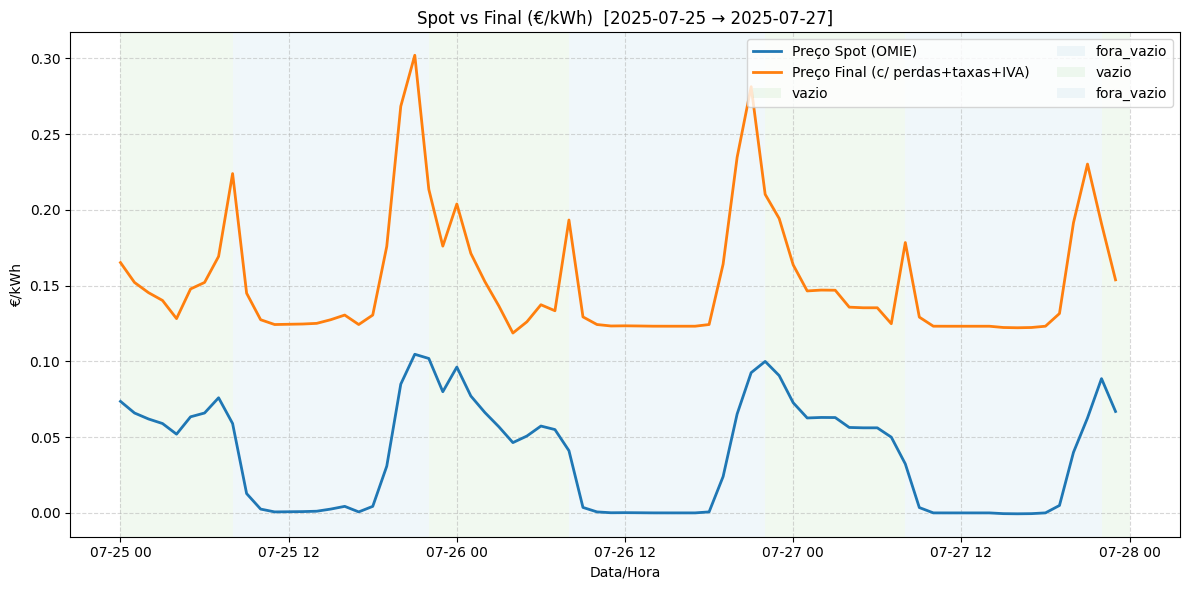

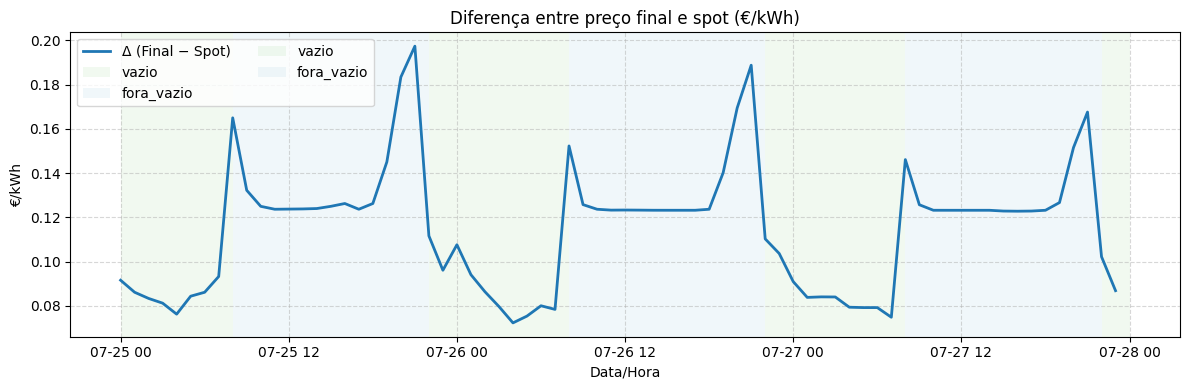

In [95]:
# %% [markdown]
# ### REN Day-Ahead -> €/kWh + Tarifas + Gráficos (com marcação dos períodos)
# - Vai à API REN no formato xAxis.categories + series[name=="PT"].data
# - Constrói df com Date/Hour/Price_PT_€/MWh
# - Converte para €/kWh com índice datetime (Hour 1..24 -> 00..23)
# - Aplica apply_indexed_tariff (k1, k2, perdas, períodos, IVA)
# - Plota Spot vs Final, Diferença e **marca os períodos tarifários**

# %%
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from datetime import datetime, timedelta

# ==========================
# 1) Motor de períodos/tarifa (igual ao teu)
# ==========================

def _is_summer(date: datetime) -> bool:
    return 4 <= date.month <= 10

def _minutes(t) -> int:
    return t.hour * 60 + t.minute

def _period_daily(ts: datetime, option: str, season: str) -> str:
    m = _minutes(ts.time())
    if option == 'bi':
        if m >= 22 * 60 or m < 8 * 60:
            return 'vazio'
        return 'fora_vazio'
    if option == 'tri':
        if m >= 22 * 60 or m < 8 * 60:
            return 'vazio'
        if season == 'winter':
            if (8 * 60 + 30) <= m < (10 * 60 + 30) or (18 * 60) <= m < (20 * 60 + 30):
                return 'ponta'
            return 'cheias'
        else:  # summer
            if (10 * 60 + 30) <= m < (12 * 60) or (19 * 60 + 30) <= m < (21 * 60):
                return 'ponta'
            return 'cheias'
    return 'simples'

def _period_weekly(ts: datetime, option: str, season: str) -> str:
    m = _minutes(ts.time())
    wd = ts.weekday()  # Monday=0
    if option == 'bi':
        if wd <= 4:
            return 'vazio' if m < 7 * 60 else 'fora_vazio'
        if wd == 5:
            if season == 'winter':
                if m < 9 * 60 + 30 or 13 * 60 <= m < 18 * 60 + 30 or m >= 22 * 60:
                    return 'vazio'
                return 'fora_vazio'
            else:
                if m < 9 * 60 or 14 * 60 <= m < 20 * 60 or m >= 22 * 60:
                    return 'vazio'
                return 'fora_vazio'
        return 'vazio'
    if option == 'tri':
        if wd <= 4:
            if m < 7 * 60:
                return 'vazio'
            if season == 'winter':
                if 9 * 60 + 30 <= m < 12 * 60 or 18 * 60 + 30 <= m < 21 * 60:
                    return 'ponta'
                return 'cheias'
            else:
                if 9 * 60 + 15 <= m < 12 * 60 + 15:
                    return 'ponta'
                return 'cheias'
        if wd == 5:
            if season == 'winter':
                if 9 * 60 + 30 <= m < 13 * 60 or 18 * 60 + 30 <= m < 22 * 60:
                    return 'cheias'
                return 'vazio'
            else:
                if 9 * 60 <= m < 14 * 60 or 20 * 60 <= m < 22 * 60:
                    return 'cheias'
                return 'vazio'
        return 'vazio'
    return 'simples'

def get_tariff_period(ts: datetime, option: str, cycle: str) -> str:
    season = 'summer' if _is_summer(ts) else 'winter'
    if cycle == 'daily':
        return _period_daily(ts, option, season)
    return _period_weekly(ts, option, season)

def apply_indexed_tariff(prices_df: pd.DataFrame, vat_rate: float) -> pd.DataFrame:
    option = "bi"       # 'simples' | 'bi' | 'tri'
    cycle = "daily"     # 'daily' | 'weekly'
    k1 = 1.28
    k2 = 0.0172         # €/kWh
    losses = 0.085      # 8,5 %

    rates = {
        "simples": 0.0600,
        "bi": {"fora_vazio": 0.0830, "vazio": 0.0149},
        "tri": {"ponta": 0.2469, "cheias": 0.0388, "vazio": 0.0149}
    }

    periods, tariffs, finals = [], [], []
    for ts, row in prices_df.iterrows():
        period = get_tariff_period(ts, option, cycle)
        periods.append(period)
        if option == 'simples':
            tar = rates['simples']
        elif option == 'bi':
            tar = rates['bi'][period]
        elif option == 'tri':
            tar = rates['tri'][period]
        else:
            tar = 0.0
        tariffs.append(tar)
        final_price = (row['price_omie_eur_kwh'] * (1 + losses) * k1 + k2 + tar) * (1 + vat_rate)
        finals.append(final_price)

    out = prices_df.copy()
    out['tariff_period'] = periods
    out['tariff_energy_eur_kwh'] = tariffs
    out['price_final_eur_kwh'] = finals
    return out

# ==========================
# 2) Fetch REN (xAxis/series) -> DataFrame
# ==========================

REN_URL = "https://servicebus.ren.pt/datahubapi/electricity/ElectricityMarketPricesDaily"

def fetch_ren_prices_range_xaxis_series(start_date: str, end_date: str, culture: str = "pt-PT", pause_s: float = 0.15) -> pd.DataFrame:
    start = datetime.fromisoformat(start_date).date()
    end = datetime.fromisoformat(end_date).date()
    if end < start:
        raise ValueError("end_date < start_date")

    rows_all = []
    sess = requests.Session()
    d = start
    while d <= end:
        date_str = d.isoformat()
        params = {"culture": culture, "date": date_str}
        r = sess.get(REN_URL, params=params, timeout=20)
        r.raise_for_status()
        j = r.json()

        if not isinstance(j, dict) or "xAxis" not in j or "series" not in j:
            raise ValueError(f"Resposta inesperada para {date_str}: chaves={list(j) if isinstance(j, dict) else type(j)}")

        hours = j["xAxis"].get("categories", [])
        if not hours:
            raise ValueError(f"Sem xAxis.categories para {date_str}")

        series_pt = None
        for s in j["series"]:
            if isinstance(s, dict) and s.get("name") == "PT":
                series_pt = s
                break
        if series_pt is None:
            raise ValueError(f"Não encontrei série 'PT' em {date_str}; séries: {[s.get('name') for s in j['series'] if isinstance(s, dict)]}")

        prices = series_pt.get("data", [])
        if len(prices) != len(hours):
            raise ValueError(f"Tamanho mismatch em {date_str}: {len(prices)} preços vs {len(hours)} horas")

        for h_str, price in zip(hours, prices):
            try:
                h = int(h_str)
            except Exception:
                h = int(str(h_str).strip("hH "))
            rows_all.append({"Date": date_str, "Hour": h, "Price_PT_€/MWh": float(price)})

        time.sleep(pause_s)
        d += timedelta(days=1)

    df = pd.DataFrame(rows_all).sort_values(["Date", "Hour"])
    df["datetime"] = pd.to_datetime(df["Date"]) + pd.to_timedelta(df["Hour"] - 1, unit="h")
    df["price_omie_eur_kwh"] = df["Price_PT_€/MWh"] / 1000.0
    return df.set_index("datetime")

# ==========================
# 3) Utilitário: sombrear períodos no gráfico
# ==========================

# Cores para os períodos (ajusta se quiseres)
PERIOD_COLORS = {
    'vazio':      '#a1d99b',  # verde claro
    'fora_vazio': '#9ecae1',  # azul claro
    'cheias':     '#9ecae1',  # igual a fora_vazio
    'ponta':      '#fb6a4a',  # vermelho suave
    'simples':    '#d9d9d9'   # cinza
}

def shade_periods(ax, df, period_col='tariff_period', alpha=0.15):
    """
    Desenha faixas contínuas por período no eixo X.
    Retorna handles (Patch) para legenda.
    """
    if df.empty:
        return []

    idx = df.index
    periods = df[period_col].astype(str).values

    labels_added = set()
    seg_start = idx[0]
    seg_period = periods[0]
    handles = []

    for i in range(1, len(idx)):
        if periods[i] != seg_period:
            h = ax.axvspan(seg_start, idx[i], facecolor=PERIOD_COLORS.get(seg_period, '0.9'), alpha=alpha,
                           label=None if seg_period in labels_added else seg_period)
            if seg_period not in labels_added:
                handles.append(Patch(facecolor=PERIOD_COLORS.get(seg_period, '0.9'), alpha=alpha, label=seg_period))
                labels_added.add(seg_period)
            seg_start = idx[i]
            seg_period = periods[i]

    # último segmento (até +1h para cobrir a última hora)
    ax.axvspan(seg_start, idx[-1] + pd.Timedelta(hours=1), facecolor=PERIOD_COLORS.get(seg_period, '0.9'), alpha=alpha,
               label=None if seg_period in labels_added else seg_period)
    if seg_period not in labels_added:
        handles.append(Patch(facecolor=PERIOD_COLORS.get(seg_period, '0.9'), alpha=alpha, label=seg_period))
        labels_added.add(seg_period)

    return handles

# ==========================
# 4) Executar: fetch -> tarifa -> gráficos
# ==========================

START = "2025-07-25"
END   = "2025-07-27"
CULT  = "pt-PT"
VAT   = 0.23

prices_df = fetch_ren_prices_range_xaxis_series(START, END, culture=CULT)
priced = apply_indexed_tariff(prices_df, vat_rate=VAT)

# Mostrar alguns registos
display_cols = ["Date", "Hour", "Price_PT_€/MWh", "price_omie_eur_kwh", "tariff_period", "tariff_energy_eur_kwh", "price_final_eur_kwh"]
display(priced[display_cols].head(12))

# Gráfico 1 — Spot vs Final com faixas de período
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(priced.index, priced["price_omie_eur_kwh"], label="Preço Spot (OMIE)", linewidth=2)
ax.plot(priced.index, priced["price_final_eur_kwh"], label="Preço Final (c/ perdas+taxas+IVA)", linewidth=2)
period_handles = shade_periods(ax, priced, period_col='tariff_period', alpha=0.15)
handles, labels = ax.get_legend_handles_labels()
handles = handles + period_handles
labels  = labels  + [h.get_label() for h in period_handles]
ax.legend(handles, labels, ncol=2)
ax.set_title(f"Spot vs Final (€/kWh)  [{START} → {END}]")
ax.set_xlabel("Data/Hora")
ax.set_ylabel("€/kWh")
ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Gráfico 2 — Diferença (Final − Spot) com faixas de período
diff = priced["price_final_eur_kwh"] - priced["price_omie_eur_kwh"]
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(diff.index, diff.values, label="Δ (Final − Spot)", linewidth=2)
period_handles = shade_periods(ax, priced, period_col='tariff_period', alpha=0.15)
handles, labels = ax.get_legend_handles_labels()
handles = handles + period_handles
labels  = labels  + [h.get_label() for h in period_handles]
ax.legend(handles, labels, ncol=2)
ax.set_title("Diferença entre preço final e spot (€/kWh)")
ax.set_xlabel("Data/Hora")
ax.set_ylabel("€/kWh")
ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


